# Исследование поведения пользователей мобильного приложения

**Описание проекта:** 

Исследование поведения пользователей мобильного приложения стартапа, который продает продукты питания, а так же результатов проведенного A/A/B-эксперимента.

**Описание данных:**

Файл /datasets/logs_exp.csv содержит информацию о действиях пользователей: 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План выполнения проекта:**

1. Загрузка данных и изучение общей информации.


2. Подготовка данных.
- Замена названия столбцов;
- Проверка пропусков и типов данных;
- Добавление столбца даты и времени, а также отдельного столбца дат.

3. Изучение и проверка данных.
- Определение количества событий в логе.
- Определение количества пользователей в логе.
- Определение среднего количества событий на одного пользователя.
- Изучение данных во времени.

4. Изучение воронки событий.
- Определение типов событий в логах и их частоты.
- Определение доли пользователей, совершавших события.
- Построение воронки событий.

5. Изучение результатов эксперимента.
- Определение количества пользователей в каждой экспериментальной группе.
- Проверка критериев успешного А/А-теста.
- Проведение А/А-теста.
- Проведение А/В-теста.

6. Общие выводы.

### Загрузка данных и изучение общей информации

In [29]:
# Импортирую нужные библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from math import floor
import math as mth
from scipy import stats as st
import warnings
from plotly import graph_objects as go
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', False)
pd.set_option("display.float_format", "{:.2f}".format)

In [30]:
# Загружаю данные
try: logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except: logs = pd.read_csv('logs_exp.csv', sep='\t')

In [31]:
# Изучаю общую информацию о данных
display(logs.head())
display(logs.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

**Вывод**
- Пропуски в данных отсутствуют.
- Следует привести названия столбцов в соответствие с "хорошим стилем".
- Необходимо изменить тип данных в столбце EventTimestamp на datetime.

### Подготовка данных

In [32]:
# Изменяю названия столбцов
logs = logs.rename(columns={
    'EventName':'event_name', 
    'DeviceIDHash':'user_id', 
    'EventTimestamp':'event_time', 
    'ExpId':'group'
})

In [33]:
# Изменяю тип данных в столбце event_time на datetime
logs.event_time = pd.to_datetime(logs['event_time'], unit = 's')

In [34]:
# Добавляю столбец с датой
logs['event_date'] = logs.event_time.dt.date

In [35]:
# Изучаю измененный датафрейм
display(logs.head())
display(logs.info())

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   event_date  244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

In [36]:
# Определяю число дубликатов и их долю в общем числе записей 
print('Число дубликатов: ', logs.duplicated().sum())
print(f'Доля дубликатов в общем числе записей: {logs.duplicated().sum()/logs.shape[0]:.2%}')

Число дубликатов:  413
Доля дубликатов в общем числе записей: 0.17%


Доля дубликатов составила менее половины процента от общего числа записей, поэтому их можно удалить.

In [37]:
# Удаляю дубликаты и проверяю их наличие после удаления
logs = logs.drop_duplicates().reset_index(drop=True)
logs.duplicated().sum()

0

**Вывод**
- Названия столбцов изменены в соответствии с "хорошим стилем".
- Тип данных в столбце event_time изменен на datetime.
- Добавлен столбец с датой.
- Удалены дубликаты.

### Изучение и проверка данных

In [38]:
# Определяю количество событий в логе
print(f'Количество событий в логе: {len(logs)}.')

Количество событий в логе: 243713.


In [39]:
# Определяю количество пользователей в логе
print(f'Количество пользователей в логе: {len(logs.user_id.unique())}.')

Количество пользователей в логе: 7551.


In [40]:
# Определяю, сколько событий приходится в среднем на одного пользователя
print(f'В среднем на пользователя приходится {int(len(logs) / len(logs.user_id.unique()))} события.')

В среднем на пользователя приходится 32 события.


In [41]:
# Определяю за какой период имеются данные, для этого определяю минимальную и максимальную даты
print(logs.event_time.min())
print(logs.event_time.max())

2019-07-25 04:43:36
2019-08-07 21:15:17


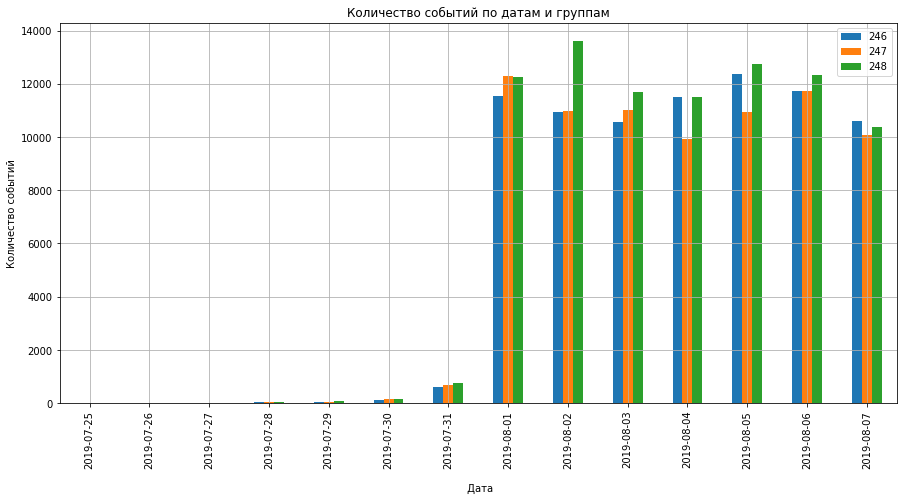

In [42]:
# Построю столбчатую диаграмму, которая отобразит количество событий по датам и группам
logs_by_date = logs.pivot_table(index = 'event_date', columns= 'group', values='event_name', aggfunc='count')
logs_by_date.plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Количество событий по датам и группам')
plt.xlabel('\n Дата')
plt.ylabel('Количество событий')
plt.legend(sorted(logs['group'].unique()));

Для анализа имеются данные за 2 недели с 25.07.2019 по 07.08.2019. На графике видно, что в первую неделю событий совсем мало. С 01.08.2019 произошло резкое увеличение количества событий. Вероятно с этой даты началась некая рекламная кампания. Поэтому данные за первую неделю нельзя считать актуальными. Среди оставшихся пользователей имеются пользователи из всех 3-х групп, что так же видно на графике. Т.о. данные за первую неделю можно отбросить и рассматривать данные за период с 01.08.2019 по 07.08.2019.

In [43]:
# Отфильтрую данные по дате
logs_1w = logs.query('event_date < datetime(2019, 8, 1).date()')
logs_2w = logs.query('event_date > datetime(2019, 7, 31).date()')

In [44]:
# Определяю долю событий и количество пользователей, оставшихся после фильтрации
print(f'Доля событий за вторую неделю: {(len(logs_2w) / len(logs)):.2%}')
print(f'Доля пользователей второй недели: {len(logs_2w.user_id.unique())/len(logs.user_id.unique()):.2%}.')

Доля событий за вторую неделю: 98.84%
Доля пользователей второй недели: 99.77%.


In [45]:
# Проверяю наличие пользователей из всех групп после фильтрации
logs_2w.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [46]:
# Определяю количество событий в логе после фильтрации
print(f'Количество событий в логе после фильтрации: {len(logs_2w)}.')

Количество событий в логе после фильтрации: 240887.


In [47]:
# Определяю количество пользователей в логе после фильтрации
print(f'Количество пользователей в логе после фильтрации: {len(logs_2w.user_id.unique())}.')

Количество пользователей в логе после фильтрации: 7534.


Расчитаю долю событий и пользователей, потерянных после фильтрации.

In [48]:
event_lost_share = 1 - len(logs_2w)/len(logs)
users_lost_share = 1 - len(logs_2w.user_id.unique())/len(logs.user_id.unique())
print(f'Доля потерянных событий: {(event_lost_share):.2%}.')
print(f'Доля потерянных пользователей: {(users_lost_share):.2%}.')

Доля потерянных событий: 1.16%.
Доля потерянных пользователей: 0.23%.


In [49]:
# Определяю, сколько событий приходится в среднем на одного пользователя после фильтрации
print(f'В среднем на пользователя после фильтрации приходится {int(len(logs_2w) / len(logs_2w.user_id.unique()))} событие.')

В среднем на пользователя после фильтрации приходится 31 событие.


**Вывод**

Изначально для анализа были предоствлены данные за 2 недели с 25.07.2019 по 07.08.2019. Но данные за первую неделю признаны неактуальными и удалены из анализа. После фильтрации событий по датам потеряно чуть больше 1% событий и менее 1% пользователей. В полученном датафрейме количество событий в логе: 240887, количество пользователей в логе: 7534, в среднем на пользователя приходится 31 событие. 

### Изучение воронки событий

In [50]:
# Определяю, какие события есть в логах
logs_2w['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

В логах представлены следующие события:
- Tutorial - обучение
- MainScreenAppear - просмотр главной страницы
- OffersScreenAppear - просмотр страницы товара
- CartScreenAppear - просмотр корзины
- PaymentScreenSuccessful - переход на страницу успешной оплаты

In [51]:
# Определяю частоту событий
events = (
    logs_2w.groupby('event_name')
    .agg({'event_name':'count'}) 
    .rename(columns={'event_name':'event_count'})
    # столбец 'event_count' - количество событий
    .sort_values(by ='event_count', ascending=False)
    .reset_index()
)
events

,event_name,event_count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Самым частым событием является просмотр главной страницы, самым редким - обучение.

In [52]:
# Определяю количество и долю пользователей, совершивших каждое событие
events = (
    logs_2w.groupby('event_name')
    .agg({'event_name':'count', 'user_id': 'nunique'})
    .rename(columns={'event_name':'event_count', 'user_id':'users_count'})
    # столбец 'event_count' - количество событий
    # столбец 'users_count' - количество пользователей, совершивших событие
    .sort_values(by ='users_count', ascending=False)
    .reset_index()
)
# доля пользователей, совершивших событие
events['user_share'] = events['users_count'] / logs_2w['user_id'].nunique()*100 

events

,event_name,event_count,users_count,user_share
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


При сортировке событий по числу пользователей, которые их совершили, также самым популярным событием остался просмотр главной страницы, самым редким - обучение. Логично предположить, что события происходят в следующей постледовательности: просмотр главной страницы - просмотр страницы товара - просмотр корзины - переход на страницу успешной оплаты. При этом обучение не является обязательным событием и не входит в эту последовательную цепочку. Поэтому обучение не будет учитываться при расчете воронки.

In [53]:
# Построю воронку событий с помощью функции
def funnel(df):
    events = (
    df.groupby('event_name')
    .agg({'event_name':'count', 'user_id': 'nunique'})
    .rename(columns={'event_name':'event_count', 'user_id':'users_count'})
    # столбец 'event_count' - количество событий
    # столбец 'users_count' - количество пользователей, совершивших событие    
    .sort_values(by ='event_count', ascending=False)
    .reset_index()
)
    # доля пользователей, совершивших событие
    events['user_share'] = events['users_count'] / df['user_id'].nunique()*100 
    # доля пользователей, перешедших на следующее событие
    events['conv'] = events['users_count'] / events['users_count'].shift(1)*100 
    events = events[:4]
    return events

In [54]:
funnel_logs_2w = funnel(logs_2w)
funnel_logs_2w

,event_name,event_count,users_count,user_share,conv
0,MainScreenAppear,117328,7419,98.47,NaN
1,OffersScreenAppear,46333,4593,60.96,61.91
2,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78


Расчитаю долю пользователей, которые доходят от первого события до оплаты.

In [55]:
user_share_all_steps = funnel_logs_2w['users_count'][3]/funnel_logs_2w['users_count'][0]
print(f'Доля пользователей, дошедших от первого события до оплаты: {(user_share_all_steps):.1%}')

Доля пользователей, дошедших от первого события до оплаты: 47.7%


Строю график воронки событий по количеству пользователей.

In [56]:
fig = go.Figure(go.Funnel(
    y = funnel_logs_2w['event_name'],
    x = funnel_logs_2w['users_count'])
               )
fig.update_layout(title={'x': 0.5, 'text': 'Воронка событий по количеству пользователей'})
fig.show()

**Вывод**

Наиболее часто встречающееся событие в логе - просмотр главной страницы. Его совершали 7419 пользователей из 7534. Таким образом 1,53% пользователей пропустили это событие и перешли сразу на страницу товара. Вероятно они это сделали по внешней ссылке. 

События происходят в следующем порядке: просмотр главной страницы - просмотр страницы товара - просмотр корзины - переход на страницу успешной оплаты. 

Самое редкое событие - обучение. Оно не входит в последовательную цепочку событий.

Исходя из получившейся воронки событий видно, что больше всего пользователей (38.09%) теряются при переходе с главной страницы на страницу товара. Доля пользователей, прошедших все события от просмотра главной страницы до успешной оплаты, составляет 47.7%. При этом стоит отметить, что при переходе от просмотра корзины на страницу успешной оплаты теряется около 5.22% пользователей. Возможно возникают какие-то технические неполадки при оплате товаров.

### Изучение результатов эксперимента

In [57]:
# Определяю количество пользователей в каждой эксперементальной группе, а также в сумме в двух контрольных группах
users_by_groups = logs_2w.groupby('group', as_index=True)['user_id'].nunique()
users_by_groups['246+247'] = users_by_groups[246] + users_by_groups[247]
users_by_groups

group
246        2484
247        2513
248        2537
246+247    4997
Name: user_id, dtype: int64

In [58]:
# Определяю количество пользователей на каждое событие в разрезе групп:
events_by_groups = (
    logs_2w.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
                  )
events_by_groups['246+247'] = events_by_groups[246] + events_by_groups[247]
events_by_groups = events_by_groups[:4]
events_by_groups

group,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


**А/А-тест**

Для А/А-эксперимента представлены 2 контрольные группы, чтобы проверить корректность всех механизмов и расчётов. Проверю, находят ли статистические критерии разницу между выборками 246 и 247.

*Критерии успешного A/A-теста:*
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [59]:
# Расчитаю на сколько отличаются размеры контрольных групп
print( 
    'Отличие размеров контрольных групп составляет', 
    round((1-(users_by_groups[246]/users_by_groups[247]))*100, 2), '%'
    )

Отличие размеров контрольных групп составляет 1.15 %


In [60]:
# Проверю, есть ли пользователи, которые встречаются в обеих контрольных группах
len(np.intersect1d(logs_2w.query('group == 246')['user_id'].unique(), logs_2w.query('group == "247"')['user_id'].unique()))

0

Проверю, есть ли пользователи, которые пересекаются в двух группах.

In [61]:
len(np.intersect1d(logs_2w.query('group == 248')['user_id'].unique(), logs_2w.query('group == "247"')['user_id'].unique()))

0

In [62]:
len(np.intersect1d(logs_2w.query('group == 248')['user_id'].unique(), logs_2w.query('group == "246"')['user_id'].unique()))

0

Пользователи, которые встречаются одновременно в каких-либо двух группах, отсутствуют.

Число пользователей в группах отличается на 1.15%, это больше, чем 1%, но не критично. Пользователи, которые встречаются в обеих контрольных группах, отсутствуют. По этим параметрам, полагаю, можно считать данные контрольных групп корректными.

Для того, чтобы проверить, будет ли отличие между группами статистически достоверным, проведу Z-тест на равенство долей для контрольных групп. 

Построю воронки событий для каждой контрольной группы.

In [63]:
logs_246 = logs_2w.query('group == 246')
print('Воронка событий для группы 246')
display(funnel(logs_246))

Воронка событий для группы 246


,event_name,event_count,users_count,user_share,conv
0,MainScreenAppear,37676,2450,98.63,NaN
1,OffersScreenAppear,14767,1542,62.08,62.94
2,CartScreenAppear,14690,1266,50.97,82.10
3,PaymentScreenSuccessful,11852,1200,48.31,94.79


In [64]:
logs_247 = logs_2w.query('group == 247')
print('Воронка событий для группы 247')
display(funnel(logs_247))

Воронка событий для группы 247


,event_name,event_count,users_count,user_share,conv
0,MainScreenAppear,39090,2476,98.53,NaN
1,OffersScreenAppear,15179,1520,60.49,61.39
2,CartScreenAppear,12434,1238,49.26,81.45
3,PaymentScreenSuccessful,9981,1158,46.08,93.54


Формулирую гипотезы:

- Н0 : конверсии групп не отличаются,
- Н1 : конверсии групп отличаются.

Размеры групп превышают 2 тыс. пользователей. Это достаточно большие выборки, которые позволяют установить небольшой коэффициент статистической значимости, что будет означать также и небольшую вероятность ошибки первого рода. Коэффициент статистической значимости принимаю равным 0.01.

Задаю функцию z_test(group_1, group_2, alpha, event) для проведения z-теста для проверки гипотезы о равенстве долей двух выборок, где:

- group_1, group_2 - номера тестируемых групп,
- alpha - критический уровень статистической значимости,
- event - событие, на уровне которого мы проверяем равенство долей.

In [65]:
def z_test (group_1, group_2, alpha, event):

    # критический уровень статистической значимости
    alpha = alpha 
    
    #значения выборок на уровне тестируемого события
    successes_1 = events_by_groups.loc[event, group_1]
    successes_2 = events_by_groups.loc[event, group_2]
    
    #первоначальные значения выборок 
    trials_1 = users_by_groups[group_1] 
    trials_2 = users_by_groups[group_2]

    # пропорция успехов
    p1 = successes_1/trials_1
    p2 = successes_2/trials_2

    # пропорция успехов в комбинированном датасете
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаю статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

    # задаю стандартное нормальное распределение (среднее = 0, ст.отклонение = 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        return [group_1, group_2, event, p_value, 'отвергаем Н0']
    else:
        return [group_1, group_2, event, p_value, 'не отвергаем Н0']

Самое популярное событие в логе - просмотр главной страницы (MainScreenAppear). Провожу z_test по этому событию.

In [66]:
z_test (246, 247, 0.01, 'MainScreenAppear')

[246, 247, 'MainScreenAppear', 0.7570597232046099, 'не отвергаем Н0']

Провожу z_test по остальным событиям.

In [67]:
# Создаю список для формирования результатов теста
p = [] 
# Задаю уровень статистической значимости
alpha = 0.01
#Создаю цикл для сбора результатов тестов по событиям
for group in [[246, 247]]:
    for events in events_by_groups.index.values:
        p.append(z_test(group[0], group[1], alpha, events))
        z_test_df = pd.DataFrame(p, columns=['group_1', 'group_2', 'event', 'p_value', 'H0'])   
z_test_df

,group_1,group_2,event,p_value,H0
0,246,247,MainScreenAppear,0.76,не отвергаем Н0
1,246,247,OffersScreenAppear,0.25,не отвергаем Н0
2,246,247,CartScreenAppear,0.23,не отвергаем Н0
3,246,247,PaymentScreenSuccessful,0.11,не отвергаем Н0


Проведение 4-х z-тестов контрольных групп 246 и 247 не выявило статистически достоверных отличий между группами. На основании этого можно сделать вывод, что разбиение на группы выполнено корректно.

**А/В-тест**

Проведу аналогичные тесты с группой с измененным шрифтом и посмотрю, будет ли отличие между группами статистически достоверным.

In [68]:
# Построю воронку событий для группы 248.
logs_248 = logs_2w.query('group == 248')
print('Воронка событий для группы 248')
display(funnel(logs_248))

Воронка событий для группы 248


,event_name,event_count,users_count,user_share,conv
0,MainScreenAppear,40562,2493,98.27,NaN
1,OffersScreenAppear,16387,1531,60.35,61.41
2,CartScreenAppear,15179,1230,48.48,80.34
3,PaymentScreenSuccessful,12085,1181,46.55,96.02


In [69]:
# Создаю список для формирования результатов теста
p = [] 
#Задаю уровень статистической значимости:
alpha = 0.01
# Создаю цикл для сбора результатов тестов по событиям
for group in [[246, 248], [247, 248], ['246+247', 248]]:
    for events in events_by_groups.index.values:
        p.append(z_test(group[0], group[1], alpha, events))
        z_test_df = pd.DataFrame(p, columns=['group_1', 'group_2', 'event', 'p_value', 'H0'])   
z_test_df

,group_1,group_2,event,p_value,H0
0,246,248,MainScreenAppear,0.29,не отвергаем Н0
1,246,248,OffersScreenAppear,0.21,не отвергаем Н0
2,246,248,CartScreenAppear,0.08,не отвергаем Н0
3,246,248,PaymentScreenSuccessful,0.21,не отвергаем Н0
4,247,248,MainScreenAppear,0.46,не отвергаем Н0
5,247,248,OffersScreenAppear,0.92,не отвергаем Н0
6,247,248,CartScreenAppear,0.58,не отвергаем Н0
7,247,248,PaymentScreenSuccessful,0.74,не отвергаем Н0
8,246+247,248,MainScreenAppear,0.29,не отвергаем Н0
9,246+247,248,OffersScreenAppear,0.43,не отвергаем Н0


При проведении z-теста на всех уровнях воронки событий гипотеза о равенстве групп не была отвергнута. Группа, состоящая из суммы тестовых групп, также показала результаты, которые говорят в пользу равенства групп.

При проведении 16 тестов и использовали коэффициента статистической значимости *а* равного 0,01% возникает вероятность возникновения ложноположительного результата. Чтобы групповая вероятность ошибки не превышала определенный уровень значимости, то, согласно методу Бонферрони, следует сравнить каждое из полученных p-value не с *а*, а с *a/m* где *m* - число проверяемых гипотез. 

In [70]:
# Проведу z_test с учетом поправки Бонферрони
# Создаю список для формирования результатов теста
p = [] 
# Задаю статистической значимости:
alpha = 0.01
# Создаю цикл для сбора результатов тестов по событиям
for group in [[246, 247], [246, 248], [247, 248], ['246+247', 248]]:
    for events in events_by_groups.index.values:
        p.append(z_test(group[0], group[1], alpha, events))
        z_test_df = pd.DataFrame(p, columns=['group_1', 'group_2', 'event', 'p_value', 'H0'])   

# Задаю уровень статистической значимости с учетом поправки Бонферрони
alpha_bonferroni = alpha/len(z_test_df)
print(f'Коэффициент статистической значимости с поправкой Бонферрони: {alpha_bonferroni}')
z_test_df['H0_bonferroni'] = 'отвергаем Н0'
z_test_df['H0_bonferroni'] = z_test_df['H0_bonferroni'].where(z_test_df['p_value'] < alpha_bonferroni, 'не отвергаем Н0')
z_test_df

Коэффициент статистической значимости с поправкой Бонферрони: 0.000625


,group_1,group_2,event,p_value,H0,H0_bonferroni
0,246,247,MainScreenAppear,0.76,не отвергаем Н0,не отвергаем Н0
1,246,247,OffersScreenAppear,0.25,не отвергаем Н0,не отвергаем Н0
2,246,247,CartScreenAppear,0.23,не отвергаем Н0,не отвергаем Н0
3,246,247,PaymentScreenSuccessful,0.11,не отвергаем Н0,не отвергаем Н0
4,246,248,MainScreenAppear,0.29,не отвергаем Н0,не отвергаем Н0
5,246,248,OffersScreenAppear,0.21,не отвергаем Н0,не отвергаем Н0
6,246,248,CartScreenAppear,0.08,не отвергаем Н0,не отвергаем Н0
7,246,248,PaymentScreenSuccessful,0.21,не отвергаем Н0,не отвергаем Н0
8,247,248,MainScreenAppear,0.46,не отвергаем Н0,не отвергаем Н0
9,247,248,OffersScreenAppear,0.92,не отвергаем Н0,не отвергаем Н0


Применив поправку Бонферрони к тестам также получен результат, согласно которому отсутствует статистическая значимость между группами.

**Вывод**

К контрольным группам были применены критерии успешного тестирования: отличия между группами незначительны (1,15%), пользователи, попавшие в несколько групп, не найдены. Можно считать данные групп корректными.

Для проведения z-теста на равенство долей контрольных групп были сформулированы гипотезы:

- Н0 : конверсии групп не отличаются
- Н1 : конверсии групп отличаются

Размеры каждой из групп превышают 2 тыс. пользователей. Это достаточно большие выборки, которые позволяют установить небольшой коэффициент статистической значимости, равный 0.01, что будет означать также и небольшую вероятность ошибки первого рода.

Проведение 4 z-тестов контрольных групп 246 и 247 не выявило статистически достоверных отличий между группами, что означает, что выборки сделаны корректно.

Проведение 12 аналогичных тестов с контрольными и тестируемой группой также не выявило статистически достоверных отличий между конверсиями групп.

Был задан коэффициент статистической значимости *а*, равный 0,01%. Так как всего было проведено 16 тестов, при таком количестве возникает вероятность ошибки ложноположительного результата. Чтобы групповая вероятность ошибки в данном случае не превышала определенный уровень значимости α, была применена поправка Бонферрони к коэффициенту статистической значимости.

После применения поправки Бонферрони получен результат, согласно которому между тестовой и контрольными группами не выявлено статистически достоверных отличий.

### Общие выводы

Представленные для анализа данные содержат лог, каждая запись которого — действие пользователя мобильного приложения.

Действия пользователей разбиты на три группы: 2 контрольные и одна тестовая, для пользователей которой изменен шрифт приложения. Цель исследования - разобраться, изменилась ли конверсия в события в тестовой группе.

В результате предобработки:

- изменен стиль названий столбцов,
- тип данных в столбце event_time изменен на datetime,
- добавлен столбец с датой,
- удалены дубликаты.

Для исследования представлены данные за период с 25.07.2019 по 07.08.2019. Но актуальными можно считать только данные с 01.08.2019 по 07.08.2019. Более ранние данные были удалены, в связи с чем было потеряно чуть более 1% событий и всего 0,23% пользователей. Осталось 240887 события и 7534 пользователей.

Наиболее часто встречающееся событие в логе - просмотр главной страницы. Его совершали 7419 пользователей из 7534. События происходят в следующем порядке: просмотр главной страницы - просмотр страницы товара - просмотр корзины - переход на страницу успешной оплаты. Самое редкое событие - обучение. Оно не входит в последовательную цепочку событий.

Больше всего пользователей (38.09%) теряются при переходе с главной страницы на страницу товара. Доля пользователей, прошедших все события от просмотра главной страницы до успешной оплаты, составляет 47.7%. При этом при переходе от просмотра корзины на страницу успешной оплаты теряется около 5.22% пользователей. Возможно возникают какие-то технические неполадки при оплате товаров.

Были проведены тесты:
- 4 z-теста контрольных групп 246 и 247 в разрезе событий воронки: статистически достоверных отличий между группами не выявлено, что означает, что выборки сделаны корректно.
- 12 z-теста аналогичных тестов с контрольными и тестируемой группой: статистически достоверных отличий между конверсиями групп не выявлено.

Так как всего было проведено 16 тестов, для того, чтобы групповая вероятность ошибки не превышала определенный уровень значимости *а* равный 0.01, была применена поправка Бонферрони к коэффициенту статистической значимости.

После применения поправки Бонферрони получен результат, согласно которому между тестовой и контрольными группами не выявлено статистически достоверных отличий.

**Общий результат исследования:**

Гипотеза об отсутствии различий между конверсиями событий тестируемых групп не опровергнута.

Это означает, что разницы между поведением пользователей до изменения шрифта приложения и после его изменения с большой долей вероятности нет. Можно оставить шрифт прежним.